In [165]:
#import modules
import matplotlib.pyplot as plt
import pyabf
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import datetime


%matplotlib notebook

In [217]:
def abf_to_arrays(abf,channel = 0):
    num_of_sweeps = len(abf.sweepList)
    Y = np.zeros((num_of_sweeps,abf.sweepPointCount))
    X = np.zeros((num_of_sweeps,abf.sweepPointCount))
    C = np.zeros((num_of_sweeps,abf.sweepPointCount))
    for sweep in abf.sweepList:
        abf.setSweep(sweep,channel=channel)
        Y[sweep,:] = abf.sweepY
        X[sweep,:] = abf.sweepX
        C[sweep,:] = abf.sweepC
    return X,Y,C


def extract_spikes(sweep, timebase, find_peaks_kwargs = {'height':0}):
    spike_indices, prop_dict = find_peaks(sweep, **find_peaks_kwargs)
    spike_times = timebase[spike_indices]
    spike_peak_voltages = prop_dict['peak_heights']
    return spike_times, spike_peak_voltages, spike_indices

def extract_spikes_from_sweep_array(X, Y, C, find_peaks_kwargs = {'height':0}):
    #possibly should split up spike detection loop from current injection read-out loop
    df_list = []
    trace_df_list = []
    num_of_sweeps = Y.shape[0]
    firing_rates = np.zeros(num_of_sweeps)
    current_inj_amplitude = np.zeros(num_of_sweeps)
    for i in range(num_of_sweeps):
        try:
            inj, indices = get_current_step_parameters(sweep = C[i], timebase = X[i])
            spike_times, spike_peak_voltages, spike_indices = extract_spikes(sweep = Y[i],
                                                              timebase = X[i],
                                                              find_peaks_kwargs = find_peaks_kwargs)
            spike_dict = {'spike_times':spike_times,
                                         'spike_peak_vm':spike_peak_voltages,
                                         'spike_index':spike_indices}
            df = pd.DataFrame(spike_dict)
            df['sweep'] = i
            for key, value in inj.items():
                df[key] = value
            df_list.append(df)
            firing_rates[i] = len(spike_times)
            current_inj_amplitude[i] = inj['amplitude']
        except:
            print('no current injection')
            
    spike_times_df = pd.concat(df_list)
    spike_rates_df = pd.DataFrame({'amplitude':current_inj_amplitude,'firing_rate':firing_rates})
    return spike_times_df, spike_rates_df


def get_current_step_parameters(sweep, timebase):
    inj={}
    i_max = sweep.max()
    i_min = sweep.min()
    positive_current_inj_present = abs(i_max) > np.finfo(float).eps
    negative_current_inj_present = abs(i_min) > np.finfo(float).eps

    assert positive_current_inj_present or negative_current_inj_present

    if positive_current_inj_present : # if positive current inj
        inj['amplitude'] = i_max
    elif negative_current_inj_present: #if negative current inj
        inj['amplitude'] = i_min

    indices = np.where(abs(sweep - inj['amplitude']) < np.finfo(float).eps)[0]
    inj['start_ind'] = indices[0]
    inj['end_ind'] = indices[-1]+1 #adding one; indexes point where current = 0 again
    inj['start_time'] = timebase[inj['start_ind']]
    inj['end_time'] = timebase[inj['end_ind']]
    inj['duration'] = inj['end_time'] - inj['start_time']
    return inj, indices

In [218]:
#workflow

#select experiment (maybe build out more later)
# filepath = '/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTOM-GCaM6f_P52/t041519c_PV_0001.abf'
filepath = '/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTOM-GCaM6f_P52/t041519b_PV_0000.abf'
# load .abf files
abf = pyabf.ABF(filepath)

#convert abf files
X,Y,C = abf_to_arrays(abf)

#measure spikes and current injection metadata
spike_times_df,spike_rates_df = extract_spikes_from_sweep_array(X, Y, C, find_peaks_kwargs)

#add experiment metadata
spike_times_df['raw_filepath'] = filepath
spike_times_df['analysis_date'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
spike_times_df['recording_ID'] = 1

no current injection


In [177]:
#think about adding more metadata
# filepath.split('/')
# filepath.split('/')[-1].split('_')[0][-1]

# save data - for new master data
# save_folder = '/Volumes/brain_slice/Tsai/ephys_analysis/'
# save_path = save_folder + 'current_inj_spike_times.csv'
# df.to_csv(save_path)

# load master data, append new data, and resave

In [214]:
master_spike_times_df = pd.DataFrame().from_csv(save_path)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [227]:
new_master_df = pd.concat([master_spike_times_df,df]).reset_index()

In [257]:
master_spike_times_df.loc[11]

,spike_times,spike_peak_vm,spike_index,sweep,amplitude,start_ind,end_ind,start_time,end_time,duration,raw_filepath,analysis_date,recording_ID
11,0.3583,38.818359,3583,78,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3574,36.437988,3574,144,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3563,36.956787,3563,145,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3580,38.696289,3580,146,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3556,36.621094,3556,147,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3576,37.200928,3576,148,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3566,37.048340,3566,149,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3556,36.926270,3556,150,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3567,36.865234,3567,151,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0
11,0.3544,36.895752,3544,152,200.0,1078,3578,0.1078,0.3578,0.25,/Volumes/brain_slice/Tsai/04-15-19_PV-cre-tdTO...,2019-04-22 15:52:52,0


In [225]:
master_spike_times_df.groupby('sweep').size().mean()

11.525

In [234]:
rates_by_sweep = new_master_df.groupby(['recording_ID','sweep']).size()

In [239]:
amps_by_sweep = new_master_df.groupby(['recording_ID','sweep'])['amplitude'].mean()

<IPython.core.display.Javascript object>


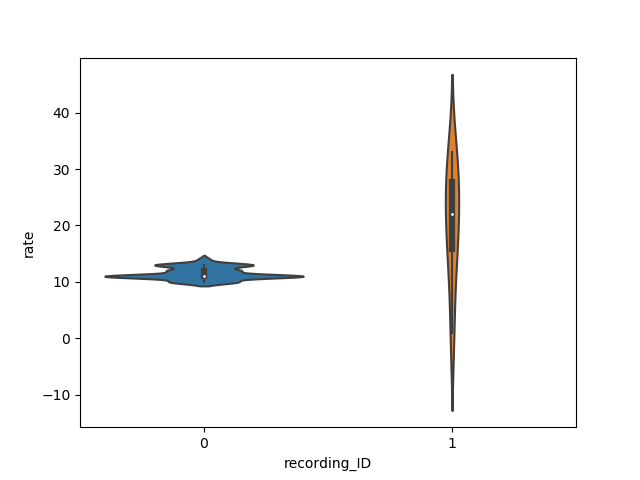

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [263]:
f,ax = plt.subplots()
sns.violinplot(data = agg_df, x = 'recording_ID', y= 'rate', ax = ax)

In [258]:
agg_df = pd.DataFrame({'amp':amps_by_sweep,'rate':rates_by_sweep}).reset_index()

In [246]:
pd.DataFrame({'amp':amps_by_sweep,'rate':rates_by_sweep}).reset_index().groupby(['recording_ID','amp']).mean()

sweep    rate
recording_ID amp                 
0            200.0  119.5  11.525
1            300.0    7.0   1.000
             350.0    8.0  12.000
             400.0    9.0  17.000
             450.0   10.0  20.000
             500.0   11.0  24.000
             550.0   12.0  27.000
             600.0   13.0  30.000
             650.0   14.0  33.000

In [241]:
.groupby(['recording_ID'])

amp  rate
recording_ID sweep             
0            0      200.0    10
             1      200.0    10
             2      200.0    10
             3      200.0    10
             4      200.0    10
             5      200.0    10
             6      200.0    10
             7      200.0    10
             8      200.0    10
             9      200.0    10
             10     200.0    10
             11     200.0    10
             12     200.0    10
             13     200.0    10
             14     200.0    10
             15     200.0    11
             16     200.0    10
             17     200.0    11
             18     200.0    11
             19     200.0    11
             20     200.0    10
             21     200.0    11
             22     200.0    10
             23     200.0    11
             24     200.0    11
             25     200.0    10
             26     200.0    11
             27     200.0    11
             28     200.0    11
             29     200.0    11
...                   ...   ...
             218    200.0    13
             219    200.0    13
             220    200.0    13
             221    200.0    13
             222    200.0    13
             223    200.0    13
             224    200.0    13
             225    200.0    13
             226    200.0    13
             227    200.0    13
             228    200.0    13
             229    200.0    13
             230    200.0    13
             231    200.0    14
             232    200.0    13
             233    200.0    13
             234    200.0    13
             235    200.0    14
             236    200.0    14
             237    200.0    14
             238    200.0    14
             239    200.0    14
1            7      300.0     1
             8      350.0    12
             9      400.0    17
             10     450.0    20
             11     500.0    24
             12     550.0    27
             13     600.0    30
             14     650.0    33

[248 rows x 2 columns]

In [174]:
filepath.split('/')
filepath.split('/')[-1].split('_')[0][-1]

'c'

In [141]:
sweep = C[0]
inj = get_current_step_parameters(sweep, timebase)


In [142]:
inj

{'amplitude': 200.0,
 'indices': array([1078, 1079, 1080, ..., 3575, 3576, 3577]),
 'start_ind': 1078,
 'end_ind': 3578,
 'start_time': 0.1078,
 'end_time': 0.3578,
 'duration': 0.25}

In [124]:
np.where(inj_timepoints)

(array([1078, 1079, 1080, ..., 3575, 3576, 3577]),)

In [102]:
def raster_plot(df,spacing = 1):
    f,ax = plt.subplots()
    ax.plot(df['spike_times'],df['sweep'] * spacing,'.',alpha = 0.3)
    ax.set_title('raster')
    ax.set_xlim((0,0.5))
    return f,ax 

<IPython.core.display.Javascript object>


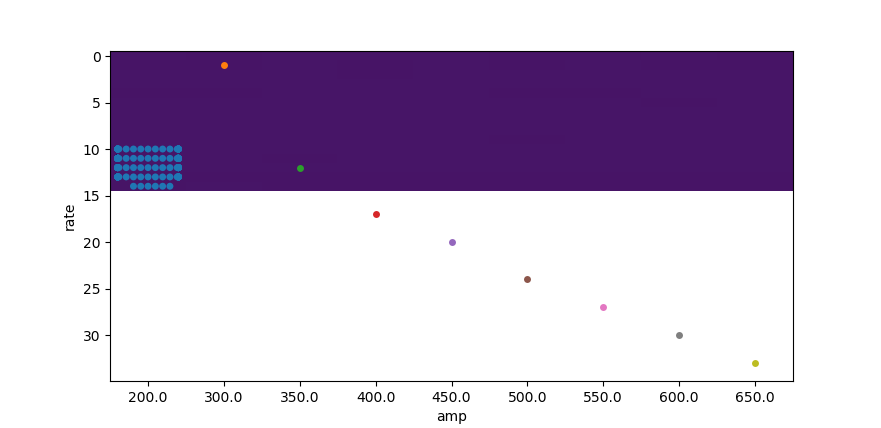

In [182]:
f,ax = plt.subplots()
ax.imshow(Y,aspect = 'auto')

<IPython.core.display.Javascript object>


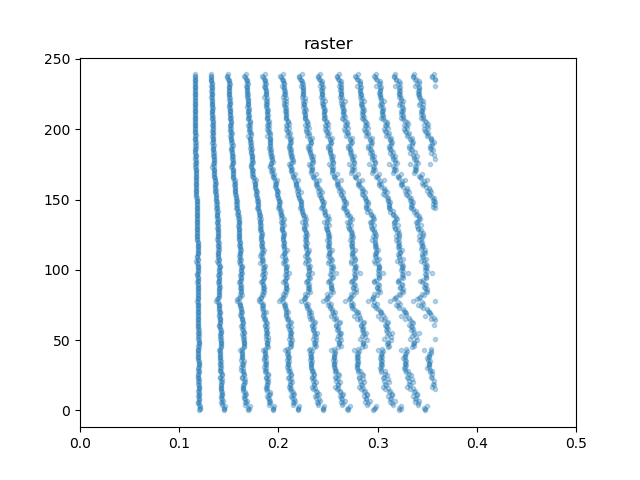

(0, 0.5)

In [108]:
f,ax = plt.subplots()
ax.plot(df['spike_times'],df['sweep'],'.',alpha = 0.3)
ax.set_title('raster')
ax.set_xlim((0,0.5))

In [81]:
pd.DataFrame({'spike_times':spike_times,'spike_peak_vm':spike_peak_voltages,'spike_index':spike_indices})

,spike_times,spike_peak_vm,spike_index
0,0.1203,41.229248,1203
1,0.1450,38.818359,1450
2,0.1698,38.879395,1698
3,0.1948,38.238525,1948
4,0.2197,38.177490,2197
5,0.2449,38.238525,2449
6,0.2702,38.085938,2702
7,0.2957,37.841797,2957
8,0.3216,37.750244,3216
9,0.3478,38.116455,3478


In [21]:
test_trace = Y[0]

In [26]:
test_list = list(test_trace)

In [11]:
Y = np.stack(Y)
#opto = np.stack(opto)
x = abf.sweepX

array([0.    , 0.0001, 0.0002, ..., 0.4997, 0.4998, 0.4999])

<IPython.core.display.Javascript object>


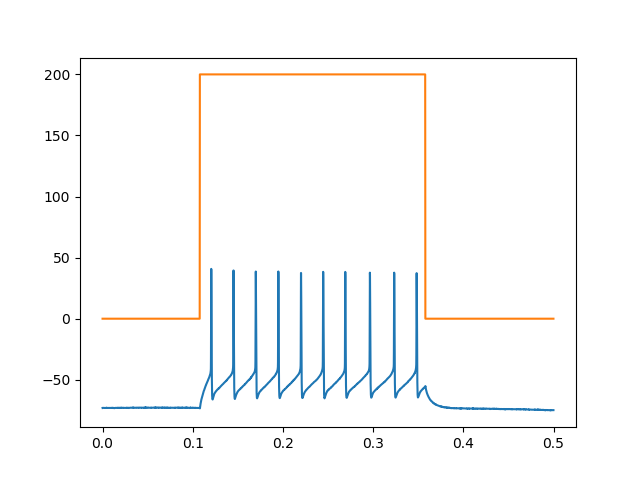

In [9]:
abf.setSweep(1)
plt.plot(abf.sweepX, abf.sweepY)
plt.plot(abf.sweepX, abf.sweepC)
plt.show()




#'/Volumes/brain_slice/Tsai/03-27-19_PV-cre-tdTOM-Cheata_P75/t032719a_PV_0003.abf'

In [4]:
print(abf)

NameError: name 'abf' is not defined

In [84]:
print(abf.headerText) # display header information in the console
abf.headerLaunch()


### ABF Class Methods ###
abf.launchInClampFit()
abf.saveABF1()
abf.setSweep()
abf.sweepD()

### ABF Class Variables ###
abfDateTime = 2019-03-27 17:26:28.582000
abfDateTimeString = 2019-03-27T17:26:28.582
abfFileComment =
abfFilePath = /Volumes/brain_slice/Tsai/03-27-19_PV-cre-tdTOM-Cheata_P75/t032719a_PV_0003.abf
abfID = t032719a_PV_0003
abfVersion = {'major': 2, 'minor': 5, 'bugfix': 0, 'build': 0}
abfVersionString = 2.5.0.0
adcNames = ['IN 0']
adcUnits = ['mV']
channelCount = 1
channelList = [0]
creatorVersion = {'major': 10, 'minor': 5, 'bugfix': 2, 'build': 6}
creatorVersionString = 10.5.2.6
dacNames = ['Cmd 0']
dacUnits = ['pA']
data = [[-75.5005 -75.47   -75.47   ... -77.8503 -77.8503 -77.9114]]
dataByteStart = 6656
dataLengthMin = 7.091666666666667
dataLengthSec = 425.5
dataPointByteSize = 2
dataPointCount = 425000
dataPointsPerMs = 10
dataRate = 10000
dataSecPerPoint = 0.0001
fileGUID = {4A674563-98C6-4ADC-BD9B-B576A1513E3E}
holdingCommand = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [281]:
abf.headerText

/anaconda3/lib/python3.7/site-packages/pyabf/abfHeaderDisplay.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if value == "~SECTION~":
/anaconda3/lib/python3.7/site-packages/pyabf/abfHeaderDisplay.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif value == "~DOCS~":


'\n### ABF Class Methods ###\nabf.launchInClampFit()\nabf.saveABF1()\nabf.setSweep()\nabf.sweepD()\n\n### ABF Class Variables ###\nabfDateTime = 2019-03-27 17:26:28.582000\nabfDateTimeString = 2019-03-27T17:26:28.582\nabfFileComment =\nabfFilePath = /Volumes/brain_slice/Tsai/03-27-19_PV-cre-tdTOM-Cheata_P75/t032719a_PV_0003.abf\nabfID = t032719a_PV_0003\nabfVersion = {\'major\': 2, \'minor\': 5, \'bugfix\': 0, \'build\': 0}\nabfVersionString = 2.5.0.0\nadcNames = [\'IN 0\']\nadcUnits = [\'mV\']\nchannelCount = 1\nchannelList = [0]\ncreatorVersion = {\'major\': 10, \'minor\': 5, \'bugfix\': 2, \'build\': 6}\ncreatorVersionString = 10.5.2.6\ndacNames = [\'Cmd 0\']\ndacUnits = [\'pA\']\ndata = [[-75.5005 -75.47   -75.47   ... -77.8503 -77.8503 -77.9114]]\ndataByteStart = 6656\ndataLengthMin = 7.091666666666667\ndataLengthSec = 425.5\ndataPointByteSize = 2\ndataPointCount = 425000\ndataPointsPerMs = 10\ndataRate = 10000\ndataSecPerPoint = 0.0001\nfileGUID = {4A674563-98C6-4ADC-BD9B-B576A15

In [85]:
abf.channelCount

1

In [30]:
y = []
#opto = []
for sweep in abf.sweepList:
    abf.setSweep(sweep,channel=0)
    y.append(abf.sweepY)
    #abf.setSweep(sweep,channel=1)
    #opto.append(abf.sweepY)
y = np.stack(y)
#opto = np.stack(opto)
x = abf.sweepX

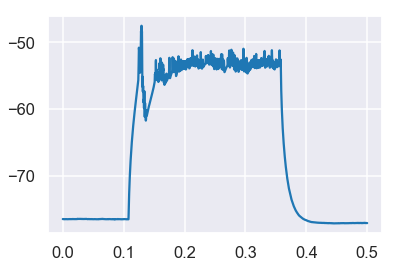

In [39]:
meansweep = np.array(y).mean(axis = 0)
plt.plot(abf.sweepX, meansweep)


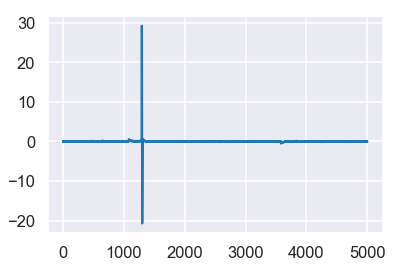

In [271]:
#find spikes method 1
dydx = np.gradient(y,axis = 1)
plt.plot(dydx[1])

In [59]:
kwarg_dict = {'height':0,'thresh':4}

In [69]:
y = Y[0]
timebase = X[0]


<IPython.core.display.Javascript object>


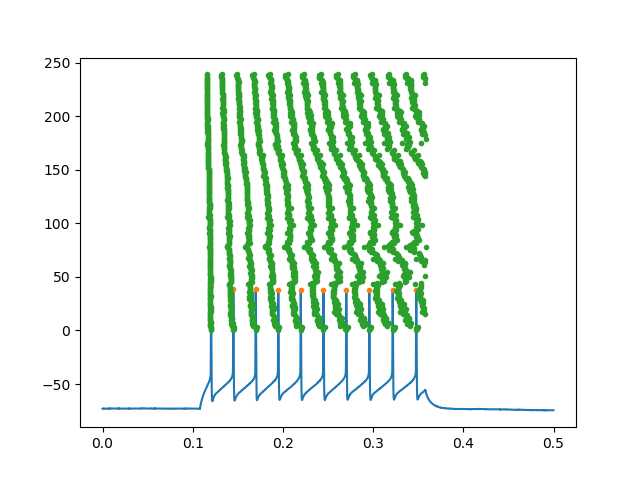

In [76]:
spike_times,spike_peak_voltages,spike_indices = extract_spikes(sweep = Y[0],
                                                               timebase = X[0],
                                                               find_peaks_kwargs = {'height':20})
plt.plot(X[0],Y[0])
plt.plot(spike_times,spike_peak_voltages,'.')

<IPython.core.display.Javascript object>


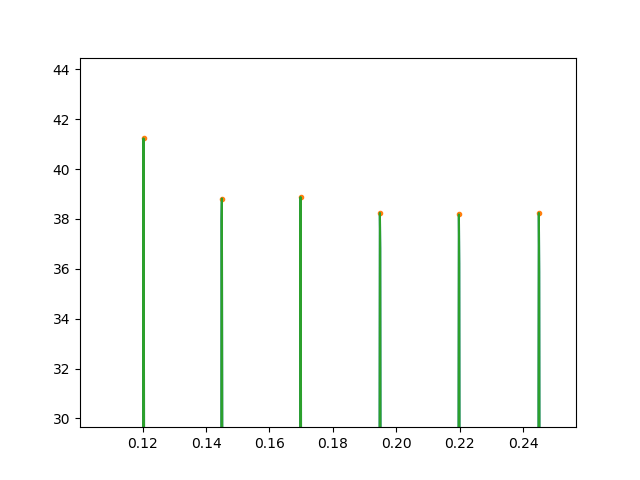

In [99]:
?plt.eventplot

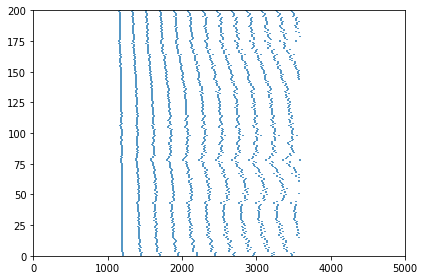

In [34]:
# rastor plot
plt.eventplot(Spikes)
plt.ylim((0,200))
plt.xlim((0,5000))
plt.tight_layout()

In [151]:
properties["peak_heights"]

array([41.8701])

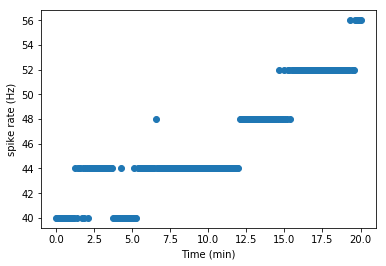

In [33]:
# allocate numbers of spikes in each sweep
SpikeNumber = []
for i in abf.sweepList:
    spkn = len(Spikes[i])
    SpikeNumber.append(spkn*4)

    
xi = [i for i in np.linspace(0, len(SpikeNumber)*5/60,len(SpikeNumber))]
plt.ylabel("spike rate (Hz)")
plt.xlabel("Time (min)")
plt.plot(xi,SpikeNumber,"o")


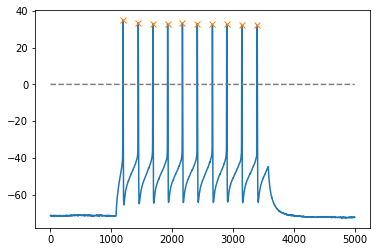

In [12]:
#ploting spike detection
plt.plot(y[81])
plt.plot(Spikes[81], y[81,Spikes[81]], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

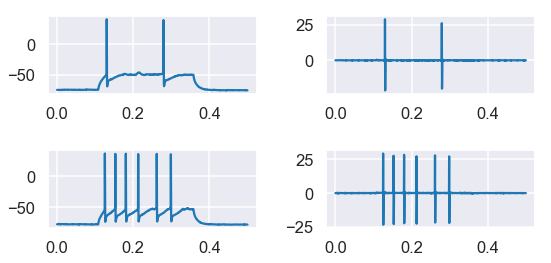

In [277]:
#another way to see spikes s

f, ax = plt.subplots(2,2,figsize = (8,4))
ax[0,0].plot(x,y[5])
ax[1,0].plot(x,y[83])

ax[0,1].plot(x,dydx[5])
ax[1,1].plot(x,dydx[83])

plt.tight_layout()
#ax[1].plot(x,opto[0,:])

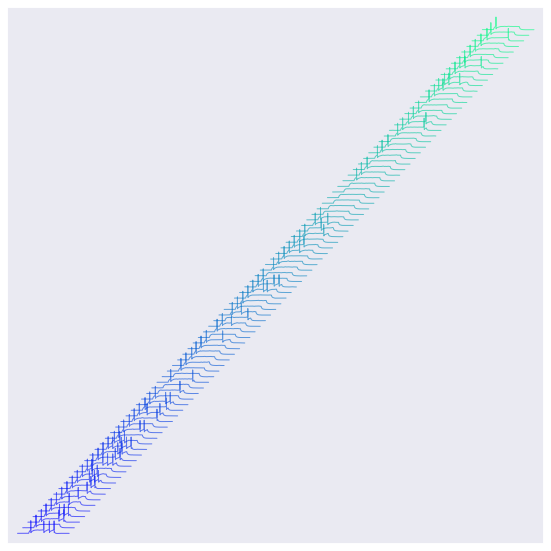

In [262]:
# use a custom colormap
cm = plt.get_cmap("winter")
colors = [cm(x/abf.sweepCount) for x in abf.sweepList]

plt.figure(figsize=(8,8))
for sweepNumber in abf.sweepList:
    plt.plot(
        x + .05 * sweepNumber,
        y[sweepNumber,:] + 50*sweepNumber,
        color=colors[sweepNumber],
        lw=1, alpha=.6)
#     plt.plot(
#         abf.sweepX[i1:i2] + 0 * sweepNumber,
#         abf.sweepY[i1:i2] + 10*sweepNumber,
#         color=colors[sweepNumber],
#         lw=.5, alpha=.6)

# remove axes and use tight margins
plt.gca().get_yaxis().set_visible(False)  # hide Y axis
plt.gca().get_xaxis().set_visible(False)  # hide X axis
plt.margins(.02, .02)
plt.tight_layout()

plt.show()

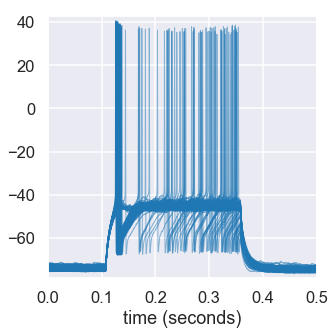

In [263]:
sns.set_context('talk')
sns.set_style('darkgrid')
f, ax = plt.subplots(1,1,figsize=(5, 5), sharey = True)

file = 0
for sweepNum in abf.sweepList:
    abf.setSweep(sweepNum)
    ax.plot(abf.sweepX, abf.sweepY,
             color='C0', lw=1, alpha = 0.5)

#     ax.set_xlim([0.1078,0.1084])
# ax.set_ylim([-600,600])
plt.xlabel(abf.sweepLabelX)
plt.xlim((0,0.5))
plt.margins(0, .02)
plt.tight_layout()

In [298]:
%matplotlib qt

<IPython.core.display.Javascript object>


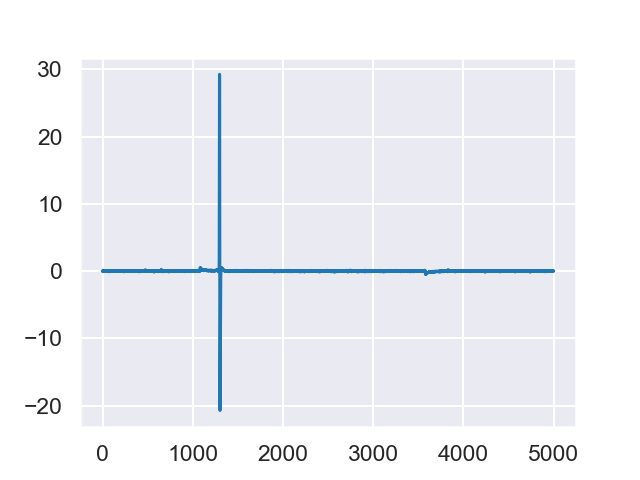

In [299]:
dydx = np.gradient(y,axis = 1)
plt.plot(dydx[1])